In [1]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms

columns = ['index', "name", "x1", "x2", "y1", "y2", "classname"]

data_csv_file = "./data/preprocessed/data.csv"
data_folder = "./data/face-mask-detection-dataset/images"
root_folder = "./data"

data_df = pd.read_csv(data_csv_file, skiprows=1, names=columns)

In [2]:
def getImageData(folder, image_file, index):
    return Image.open(os.path.join(folder, image_file)).convert('RGB') # Load the image

In [3]:

classes = {
    "face_with_mask": 0,
    "mask_colorful": 1,
    "face_no_mask": 2,
    "face_with_mask_incorrect": 3,
    "mask_surgical": 4
}


class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        for rowIndex in indexes:
            sample = {}
            sample['image'] = getImageData(data_folder, data_df[columns[1]][rowIndex], rowIndex)
            sample['target'] = classes[data_df[columns[6]][rowIndex]]
            self.dataset.append(sample)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']

In [4]:
train_split_percentage = 0.8
val_split_percentage = 0.1
test_split_percentage = 0.1
size_of_the_dataset = int(data_df.shape[0] / 15)


print("size_of_the_dataset", size_of_the_dataset)

batch_size = 4
learning_rate = 0.01
num_epochs = 4

x_direction = 180
y_direction = 180

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)


train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes))                      :int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int(
    (train_split_percentage + val_split_percentage)*len(indexes)):]


print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%")

size_of_the_dataset 680
Effective train split = 80.0%
Effective val split = 10.0%
Effective test split = 10.0%


In [5]:
transform = transforms.Compose(
    [transforms.Resize((x_direction, y_direction)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


print("Loading training set")
train_dataset = FaceMaskDataset(train_indexes, conversion=transform)
print("Loading validation set")
val_dataset = FaceMaskDataset(val_indexes, conversion=transform)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Loading training set
Loading validation set


In [6]:
# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(train_dataset[0][0].shape)

torch.Size([3, 180, 180])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        new_x_direction = x_direction+50
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=x_direction,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(x_direction),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=x_direction,
                      out_channels=x_direction, kernel_size=3, padding=1),
            nn.BatchNorm2d(x_direction),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(in_channels=x_direction,
                      out_channels=new_x_direction, kernel_size=3, padding=1),
            nn.BatchNorm2d(new_x_direction),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=new_x_direction,
                      out_channels=new_x_direction, kernel_size=3, padding=1),
            nn.BatchNorm2d(new_x_direction),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        num_of_classes = len(classes.keys())
        self.fc_layer = nn.Sequential(nn.Dropout(p=0.1), nn.Linear(45 * 45 * new_x_direction, 1000), nn.ReLU(
            inplace=True), nn.Linear(1000, 512), nn.ReLU(inplace=True), nn.Dropout(p=0.1), nn.Linear(512, num_of_classes))

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        print(x.shape)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

In [8]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

Using device: cpu


In [ ]:
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch +
          1, num_epochs, loss.item(), (correct / total) * 100))
    torch.save(model.state_dict(), os.path.join(
        root_folder, 'model', 'epoch' + str(epoch) + '.pt'))

torch.Size([4, 230, 45, 45])


In [ ]:
test_dataset = FaceMaskDataset(test_indexes, conversion=transform)
print("Loading test set")
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %' .format(
        total, (correct / total) * 100))

In [ ]:
new_data_folder = "./data/new/images"

new_images = [
    "1.png",
    "2.png",
    "3.png",
    "4.png"
]

new_image_data = []

from tqdm.notebook import tqdm
import numpy as np

for new_image in tqdm(new_images):
    image_data = transform(Image.open(os.path.join(new_data_folder, new_image)).convert('RGB'))
    image_data = image_data.numpy()
    new_image_data.append(image_data)
    
new_image_data = np.array(new_image_data, dtype="float32")
new_image_data = torch.Tensor(new_image_data)
# new_image_data = transforms.ToTensor()(new_image_data)
# new_image_data = transforms.Resize((x_direction, y_direction))(new_image_data)
# new_image_data = transforms.ToTensor()(new_image_data)
# new_image_data = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(new_image_data)

with torch.no_grad():
    labels = model(new_image_data)
    _, predicted = torch.max(labels.data, 1)
    print("Prediction: ", predicted)
    
for i, (images, labels) in enumerate(train_loader): # Forward pass
    print(labels)
    break

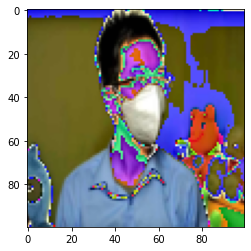

In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize((100, 100)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# new_data_folder = "./data/new/images"

# tensor_image = transforms.ToPILImage()(transform(Image.open(os.path.join(new_data_folder, '1.png'))))

# import matplotlib.pyplot as plt

# plt.imshow(tensor_image)
# plt.show()